# Exact Inversion of Chord-Length Distributions: From Particle Measurements to Size Distributions

This notebook implements the methods discussed in the article: "A Note on Exact Inversion Formulas for Recovering Diameter Distributions of Spherical Particles from Chord-Length Measurements" by J. Koiller, F. Ramos, and S. Zohren.

The code demonstrates the implementation of chord sampling and inversion methods for both 2D and 3D geometries. It provides visual comparisons between direct inversion formulas and the PAM2 algorithm for reconstructing radius distributions from chord-length measurements.

## 1. Introduction

When measuring particle size distributions in multiphase flows, instruments often detect chord lengths rather than true diameters. This creates an interesting mathematical challenge: how can we recover the original particle size distribution from these chord measurements?

This notebook implements: 1. Sampling of radii from various distributions 2. Generation of chord lengths in both 2D and 3D geometries 3. Direct inversion formulas for recovering radius distributions 4. The PAM2 (Probability Apportioning Method) algorithm for comparison 5. Visualization of the results

Let’s start by importing the necessary libraries and setting up our environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi
from scipy.special import gamma
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

# Configure plot settings for better visualization
plt.style.use('seaborn-v0_8-whitegrid')  # Modern style
plt.rcParams.update({
    "figure.dpi": 200,  # High resolution
    "font.family": "serif",  # Better for scientific plots
    "font.size": 14,
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "grid.alpha": 0.4,
    "axes.grid": True,
    "axes.spines.top": False,  # Remove top spine
    "axes.spines.right": False,  # Remove right spine
    "figure.figsize": (12, 6),  # Default figure size
})

# Configuration parameters
NUM_SAMPLES = 3000  # Number of samples for all distributions
RANDOM_SEED = 123   # Random seed for reproducibility

## 2. Defining Probability Distributions

We’ll work with four common probability distributions for particle radii, all truncated to ensure r ≥ 1 (This prevents numerical issues when radii approach zero, although it is admittedly a straightforward, and somewhat simplistic, workaround.)

In [2]:
def pdf_truncated_normal(r, mu=5.0, sigma=1.0):
    """Truncated Normal, zero for r<1."""
    if r < 1:
        return 0.0
    return (1.0/(sigma*sqrt(2*pi))) * np.exp(-0.5*((r - mu)/sigma)**2)

def pdf_lognormal(r, logmean=1.0, logstd=0.5):
    """Lognormal, zero for r<1."""
    if r < 1:
        return 0.0
    return (1.0/(r*logstd*np.sqrt(2*pi))) * np.exp(
        -(np.log(r)-logmean)**2 / (2*(logstd**2))
    )

def pdf_gamma(r, shape=2.0, scale=2.0):
    """Gamma, zero for r<1."""
    if r < 1:
        return 0.0
    return (1.0/(gamma(shape)*(scale**shape))) * (r**(shape-1))* np.exp(-r/scale)

def pdf_mixture_of_normals(r, weights=[0.4,0.6], mus=[3.0,7.0], sigmas=[1.0,1.5]):
    """Mixture of truncated Normals, zero for r<1."""
    if r < 1:
        return 0.0
    val = 0.0
    for w,m,s in zip(weights,mus,sigmas):
        val += w*(1.0/(s*sqrt(2*pi))) * np.exp(-0.5*(((r - m)/s)**2))
    return val

## 3. Sampling Radii and Chords

Next, we’ll implement functions to sample radii from our distributions and generate chord measurements in both 2D and 3D.

### 3.1 Radius Sampling via Rejection Method

In [3]:
def sample_radius(pdf_func, N=3000, r_min=1.0, r_max=15.0, rng=None):
    """
    Rejection sampling in [r_min, r_max]. PDF is zero outside.
    """
    if rng is None:
        rng = np.random.default_rng()

    # We'll evaluate the PDF over a grid just to get pdf_max
    r_test = np.linspace(r_min, r_max, 300)
    pdf_vals = np.array([pdf_func(rr) for rr in r_test])
    pdf_max = pdf_vals.max() if len(pdf_vals) > 0 else 1.0

    samples = []
    while len(samples) < N:
        rp = rng.uniform(r_min, r_max)
        yp = rng.uniform(0, pdf_max)
        if yp <= pdf_func(rp):
            samples.append(rp)
    return np.array(samples)


### 3.2 Chord Sampling in 2D (FBRM-like)

In 2D, the chord is measured as if a laser beam intersects a circular
cross-section:


In [4]:
def sample_chords_2D(radii, rng=None):
    """
    2D chord half-length y = sqrt(r^2 - x^2), x ~ Uniform(0, r).
    """
    if rng is None:
        rng = np.random.default_rng()
    xvals = rng.random(len(radii)) * radii
    chords = np.sqrt(radii**2 - xvals**2)
    return chords

### 3.3 Chord Sampling in 3D (Intrusive Probe)

In 3D, the chord is measured as if a probe pierces a spherical particle:


In [5]:
def sample_chords_3D(radii, rng=None):
    """
    3D chord half-length y = sqrt(r^2 - (r*sqrt(U))^2),
    with U ~ Uniform(0,1).
    """
    if rng is None:
        rng = np.random.default_rng()
    u = rng.random(len(radii))
    rho = radii * np.sqrt(u)
    chords = np.sqrt(radii**2 - rho**2)
    return chords

## 4. Log-Space Kernel Density Estimation (KDE)

To handle the wide range of chord lengths, we implement a log-space KDE
that provides better resolution across multiple scales:

In [6]:
def gaussian_kernel(z):
    return (1.0/np.sqrt(2.0*pi))*np.exp(-0.5*z**2)

class LogSpaceKDE:
    def __init__(self, chord_data, bandwidth=0.2):
        # Filter out non-positive values to avoid log(0)
        chord_data = chord_data[chord_data > 0]
        self.log_data = np.log(chord_data)
        self.N = len(chord_data)
        self.bandwidth = bandwidth

    def p_l(self, ell):
        ell = np.atleast_1d(ell)
        vals = np.zeros_like(ell)
        for i, e in enumerate(ell):
            z = (e - self.log_data) / self.bandwidth
            vals[i] = np.sum(gaussian_kernel(z))
        return vals / (self.N * self.bandwidth)

    def p_c(self, y):
        y = np.atleast_1d(y)
        vals = np.zeros_like(y)
        valid = (y > 0)
        ell = np.log(y[valid])
        p_l_vals = self.p_l(ell)
        vals[valid] = p_l_vals / y[valid]
        return vals

## 5. Direct Inversion Formulas

Now we implement the key mathematical contribution: direct inversion
formulas for both 2D and 3D cases.

### 5.1 2D Inversion Formula

In [7]:
def direct_inversion_2D(chord_kde, r_grid, y_max=None, num_y=300):
    """
    p_r(r) = - (2*r/pi)* d/dr [ G(r) ],
    G(r) = integral_{r to y_max} [1/sqrt(1-(r/y)^2)] * [p_c(y)/y] dy
    """
    if y_max is None:
        y_max = r_grid[-1] * 1.05

    def G(r):
        if r >= y_max:
            return 0.0
        yv = np.linspace(r, y_max, num_y)
        pc_vals = chord_kde.p_c(yv)
        integrand = []
        for i, yy in enumerate(yv):
            if yy <= r:
                integrand.append(0.0)
            else:
                denom = np.sqrt(1.0 - (r/yy)**2)
                if denom > 0:
                    integrand.append((1.0/denom)*(pc_vals[i]/yy))
                else:
                    integrand.append(0.0)
        return np.trapz(integrand, yv)

    G_vals = np.array([G(rr) for rr in r_grid])
    p_r_vals = np.zeros_like(r_grid)

    for i in range(len(r_grid)):
        if i == 0:
            # forward difference
            if len(r_grid)>1:
                dG = (G_vals[i+1]-G_vals[i])/(r_grid[i+1]-r_grid[i])
            else:
                dG = 0.0
        elif i == len(r_grid)-1:
            # backward difference
            dG = (G_vals[i]-G_vals[i-1])/(r_grid[i]-r_grid[i-1])
        else:
            dG = (G_vals[i+1]-G_vals[i-1])/(r_grid[i+1]-r_grid[i-1])

        r_ = r_grid[i]
        p_r_vals[i] = - (2*r_/pi)* dG

    # clamp negative
    p_r_vals[p_r_vals<0] = 0.0

    # normalize
    area = np.trapz(p_r_vals, r_grid)
    if area>0:
        p_r_vals /= area

    return p_r_vals

### 5.2 3D Inversion Formula

The 3D inversion formula is more direct and doesn’t require integration:


In [8]:
def direct_inversion_3D(chord_data, r_grid, bandwidth=0.15):
    """
    p_r^3(r) = - (r^2 / 2) d/dr [ p_c^3(r)/r ]
    We'll do a chord KDE to get p_c^3(r).
    """
    chord_kde = LogSpaceKDE(chord_data, bandwidth=bandwidth)
    pc_vals = chord_kde.p_c(r_grid)

    # g(r) = pc(r)/r
    g_vals = np.zeros_like(r_grid)
    mask = (r_grid>0)
    g_vals[mask] = pc_vals[mask]/r_grid[mask]

    dg = np.gradient(g_vals, r_grid)
    p_r = -0.5 * (r_grid**2)* dg
    p_r[p_r<0] = 0.0

    area = np.trapz(p_r, r_grid)
    if area>0:
        p_r /= area

    return p_r

## 6. PAM2 Algorithm for Comparison

We also implement the Probability Apportioning Method 2 (PAM2), an
iterative Bayesian approach to compare with our direct inversion
formulas:

### 6.1 Transition Matrices

In [9]:
def chord_pdf_given_r_2D(y, r):
    if (y<=0) or (y>r):
        return 0.0
    denom = np.sqrt(1.0 - (y/r)**2) if y<r else 0.0
    if denom>0:
        return (1.0/(pi*r*denom))
    else:
        return 0.0

def chord_pdf_given_r_3D(y, r):
    if (y<=0) or (y>r):
        return 0.0
    return (y/(r**2))

def construct_T_matrix_2D(radius_bin_edges, chord_bin_edges):
    r_centers = 0.5*(radius_bin_edges[:-1]+radius_bin_edges[1:])
    y_centers = 0.5*(chord_bin_edges[:-1]+chord_bin_edges[1:])
    widths = chord_bin_edges[1:] - chord_bin_edges[:-1]
    N = len(r_centers)
    M = len(y_centers)
    T = np.zeros((N, M))
    for i, r_ in enumerate(r_centers):
        row_vals = []
        for j, y_ in enumerate(y_centers):
            val = chord_pdf_given_r_2D(y_, r_)* widths[j]
            row_vals.append(val)
        s = np.sum(row_vals)
        if s>0:
            T[i,:] = np.array(row_vals)/s
        else:
            T[i,:] = 0.0
    return T, r_centers

def construct_T_matrix_3D(radius_bin_edges, chord_bin_edges):
    r_centers = 0.5*(radius_bin_edges[:-1]+radius_bin_edges[1:])
    y_centers = 0.5*(chord_bin_edges[:-1]+chord_bin_edges[1:])
    widths = chord_bin_edges[1:] - chord_bin_edges[:-1]
    N = len(r_centers)
    M = len(y_centers)
    T = np.zeros((N, M))
    for i, r_ in enumerate(r_centers):
        row_vals = []
        for j, y_ in enumerate(y_centers):
            val = chord_pdf_given_r_3D(y_, r_)* widths[j]
            row_vals.append(val)
        s = np.sum(row_vals)
        if s>0:
            T[i,:] = np.array(row_vals)/s
        else:
            T[i,:] = 0.0
    return T, r_centers

### 6.2 PAM2 Iterative Algorithm

In [10]:
def run_pam2(T, chord_bin_counts, max_iter=60, tol=1e-7):
    N, M = T.shape
    total_chords = np.sum(chord_bin_counts)
    p_r = np.ones(N)/N
    for _ in range(max_iter):
        denom = T.T @ p_r
        p_r_new = np.zeros(N)
        for j in range(M):
            if denom[j]>0:
                post_ij = (T[:,j]*p_r)/denom[j]
            else:
                post_ij = np.zeros(N)
            p_r_new += chord_bin_counts[j]* post_ij
        p_r_new /= total_chords
        diff = np.linalg.norm(p_r_new - p_r, 1)
        p_r = p_r_new
        if diff< tol:
            break
    
    # Fix for divide by zero - check if sum is zero
    p_r_sum = p_r.sum()
    if p_r_sum > 0:
        p_r /= p_r_sum
    else:
        # If all values are zero, create a uniform distribution instead
        p_r = np.ones_like(p_r) / len(p_r)
        
    return p_r

## 7. Visualization Functions

We’ll create a custom visualization function to display our results:

In [11]:
# Custom color palette
COLORS = {
    'true_pdf': '#E63946',  # Red
    'inversion': '#43AA8B',  # Teal
    'pam2': '#577590',      # Blue
    'hist': '#F1FAEE',      # Light background
    'kde': '#FFB703',       # Gold
    'background': '#F8F9FA'  # Light gray background
}

def plot_combined_results(results1, results2, filename, dimension_label):
    """
    Create a combined figure with two distributions side by side.
    
    Parameters:
    - results1, results2: tuples containing (pdf_name, r_grid, pdf_true, p_r_inv, r_centers, p_r_pam2, chords, chord_kde)
    - filename: string, filename to save the figure
    - dimension_label: string, either "2D" or "3D"
    """
    # Unpack the results
    pdf_name1, r_grid1, pdf_true1, p_r_inv1, r_centers1, p_r_pam2_1, chords1, chord_kde1 = results1
    pdf_name2, r_grid2, pdf_true2, p_r_inv2, r_centers2, p_r_pam2_2, chords2, chord_kde2 = results2
    
    # Calculate the bar widths
    if len(r_centers1) > 1:
        dr1 = r_centers1[1] - r_centers1[0]
    else:
        dr1 = 0.1
    pdf_bars1 = p_r_pam2_1/dr1
    
    if len(r_centers2) > 1:
        dr2 = r_centers2[1] - r_centers2[0]
    else:
        dr2 = 0.1
    pdf_bars2 = p_r_pam2_2/dr2
    
    # Create a figure with a custom grid layout
    fig = plt.figure(figsize=(20, 12), constrained_layout=True)
    gs = GridSpec(2, 4, figure=fig, wspace=0.3, hspace=0.4)
    
    # Set a nice background color
    fig.patch.set_facecolor(COLORS['background'])
    
    # Top left: Distribution 1 radius PDF
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax1.set_facecolor(COLORS['background'])
    
    # PAM2 bars with shadow effect
    bars1 = ax1.bar(r_centers1, pdf_bars1, width=dr1*0.8, alpha=0.7, 
                   color=COLORS['pam2'], label="PAM2", edgecolor='none',
                   zorder=10)
    
    # Add a light shadow to bars
    for bar in bars1:
        x = bar.get_x()
        width = bar.get_width()
        height = bar.get_height()
        ax1.bar(x + 0.02, height, width=width, color='gray', alpha=0.2, zorder=5)
    
    # Add the lines with nicer styling
    ax1.plot(r_grid1, p_r_inv1, '--', color=COLORS['inversion'], lw=3, 
             label=f"{dimension_label} Inversion", zorder=15)
    ax1.plot(r_grid1, pdf_true1, '-', color=COLORS['true_pdf'], lw=2.5, 
             label="True PDF", zorder=20)
    
    # Add fill under the true PDF curve
    ax1.fill_between(r_grid1, 0, pdf_true1, color=COLORS['true_pdf'], alpha=0.1)
    
    # Customize axis and labels
    ax1.set_xlabel("Radius r", fontweight='bold')
    ax1.set_ylabel("Probability Density", fontweight='bold')
    ax1.set_title(f"{pdf_name1} - Radius Distribution", fontsize=18, pad=15)
    
    # Custom legend with shadow effect
    legend = ax1.legend(loc='upper right', frameon=True, fancybox=True, 
                      framealpha=0.9, shadow=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    
    # Customize grid
    ax1.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Top right: Distribution 1 chord PDF
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax2.set_facecolor(COLORS['background'])
    
    # Histogram with nice styling
    n, bins, patches = ax2.hist(chords1, bins=40, density=True, alpha=0.6, 
                               color=COLORS['hist'], edgecolor=COLORS['pam2'], 
                               linewidth=0.5, label="Chord Data", zorder=5)
    
    # KDE line
    ygrid1 = np.linspace(0.01, chords1.max()*1.05, 300)
    pc_est1 = chord_kde1.p_c(ygrid1)
    ax2.plot(ygrid1, pc_est1, '-', color=COLORS['kde'], lw=3, 
             label="Log-KDE chord PDF", zorder=10)
    
    # Fill under the KDE curve
    ax2.fill_between(ygrid1, 0, pc_est1, color=COLORS['kde'], alpha=0.1)
    
    # Customize axis and labels
    ax2.set_xlabel("Chord half-length y", fontweight='bold')
    ax2.set_ylabel("Probability Density", fontweight='bold')
    ax2.set_title(f"{pdf_name1} - Chord Distribution", fontsize=18, pad=15)
    
    # Custom legend with shadow effect
    legend = ax2.legend(loc='upper right', frameon=True, fancybox=True, 
                       framealpha=0.9, shadow=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    
    # Customize grid
    ax2.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Bottom left: Distribution 2 radius PDF
    ax3 = fig.add_subplot(gs[1, 0:2])
    ax3.set_facecolor(COLORS['background'])
    
    # PAM2 bars with shadow effect
    bars2 = ax3.bar(r_centers2, pdf_bars2, width=dr2*0.8, alpha=0.7, 
                   color=COLORS['pam2'], label="PAM2", edgecolor='none',
                   zorder=10)
    
    # Add a light shadow to bars
    for bar in bars2:
        x = bar.get_x()
        width = bar.get_width()
        height = bar.get_height()
        ax3.bar(x + 0.02, height, width=width, color='gray', alpha=0.2, zorder=5)
    
    # Add the lines with nicer styling
    ax3.plot(r_grid2, p_r_inv2, '--', color=COLORS['inversion'], lw=3, 
             label=f"{dimension_label} Inversion", zorder=15)
    ax3.plot(r_grid2, pdf_true2, '-', color=COLORS['true_pdf'], lw=2.5, 
             label="True PDF", zorder=20)
    
    # Add fill under the true PDF curve
    ax3.fill_between(r_grid2, 0, pdf_true2, color=COLORS['true_pdf'], alpha=0.1)
    
    # Customize axis and labels
    ax3.set_xlabel("Radius r", fontweight='bold')
    ax3.set_ylabel("Probability Density", fontweight='bold')
    ax3.set_title(f"{pdf_name2} - Radius Distribution", fontsize=18, pad=15)
    
    # Custom legend with shadow effect
    legend = ax3.legend(loc='upper right', frameon=True, fancybox=True, 
                      framealpha=0.9, shadow=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    
    # Customize grid
    ax3.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Bottom right: Distribution 2 chord PDF
    ax4 = fig.add_subplot(gs[1, 2:4])
    ax4.set_facecolor(COLORS['background'])
    
    # Histogram with nice styling
    n, bins, patches = ax4.hist(chords2, bins=40, density=True, alpha=0.6, 
                               color=COLORS['hist'], edgecolor=COLORS['pam2'], 
                               linewidth=0.5, label="Chord Data", zorder=5)
    
    # KDE line
    ygrid2 = np.linspace(0.01, chords2.max()*1.05, 300)
    pc_est2 = chord_kde2.p_c(ygrid2)
    ax4.plot(ygrid2, pc_est2, '-', color=COLORS['kde'], lw=3, 
             label="Log-KDE chord PDF", zorder=10)
    
    # Fill under the KDE curve
    ax4.fill_between(ygrid2, 0, pc_est2, color=COLORS['kde'], alpha=0.1)
    
    # Customize axis and labels
    ax4.set_xlabel("Chord half-length y", fontweight='bold')
    ax4.set_ylabel("Probability Density", fontweight='bold')
    ax4.set_title(f"{pdf_name2} - Chord Distribution", fontsize=18, pad=15)
    
    # Custom legend with shadow effect
    legend = ax4.legend(loc='upper right', frameon=True, fancybox=True, 
                       framealpha=0.9, shadow=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    
    # Customize grid
    ax4.grid(True, linestyle='--', alpha=0.3, color='gray')
    
    # Add more space at the top without the suptitle
    #plt.subplots_adjust(top=0.95)
    
    # Save the figure with high resolution as PNG - commented out
    # fig.savefig(filename, dpi=600, bbox_inches='tight', format='png')
    
    # Display the figure in the notebook
    plt.show()
    
    #print(f"Figure displayed. To save it, uncomment the savefig() line.")

## 8. Complete Analysis Pipeline

Now let's put everything together into a complete analysis pipeline:

In [12]:
def analyze_distribution(pdf_name, pdf_func, dimension, rng):
    """
    Perform the full analysis chain for a single distribution.
    Returns a tuple with all results needed for plotting.
    """
    # Sample radii
    radii = sample_radius(pdf_func, N=NUM_SAMPLES, r_min=1.0, r_max=15.0, rng=rng)
    
    # Sample chords based on dimension
    if dimension == "2D":
        chords = sample_chords_2D(radii, rng=rng)
        bandwidth = 0.2
    else:  # 3D
        chords = sample_chords_3D(radii, rng=rng)
        bandwidth = 0.15
    
    # Create KDE
    chord_kde = LogSpaceKDE(chords, bandwidth=bandwidth)
    
    # Define r_grid and calculate true PDF
    r_grid = np.linspace(1.0, 15.0, 300)
    pdf_unnorm = np.array([pdf_func(rr) for rr in r_grid])
    area_ = np.trapz(pdf_unnorm, r_grid)
    pdf_true = pdf_unnorm.copy()
    if area_ > 0:
        pdf_true /= area_
    
    # Direct inversion
    if dimension == "2D":
        p_r_inv = direct_inversion_2D(chord_kde, r_grid, y_max=chords.max()*1.05, num_y=300)
    else:  # 3D
        p_r_inv = direct_inversion_3D(chords, r_grid, bandwidth=bandwidth)
    
    # PAM2
    M_chord = 30
    chord_bin_edges = np.linspace(0, chords.max()*1.05, M_chord+1)
    chord_counts, _ = np.histogram(chords, bins=chord_bin_edges)
    N_radius = 30
    r_bin_edges = np.linspace(1.0, 15.0, N_radius+1)
    
    if dimension == "2D":
        T, r_centers = construct_T_matrix_2D(r_bin_edges, chord_bin_edges)
    else:  # 3D
        T, r_centers = construct_T_matrix_3D(r_bin_edges, chord_bin_edges)
    
    p_r_pam2 = run_pam2(T, chord_counts, max_iter=80, tol=1e-7)
    
    return (pdf_name, r_grid, pdf_true, p_r_inv, r_centers, p_r_pam2, chords, chord_kde)

## 9. Running the Analysis

Finally, let's run our analysis and visualize the results:

Starting analysis with 3000 samples and random seed 123...
Analyzing 2D Normal distribution...
Analyzing 2D Mixed Normals distribution...
Creating Figure 1: 2D Normal and 2D Mixed Normals...


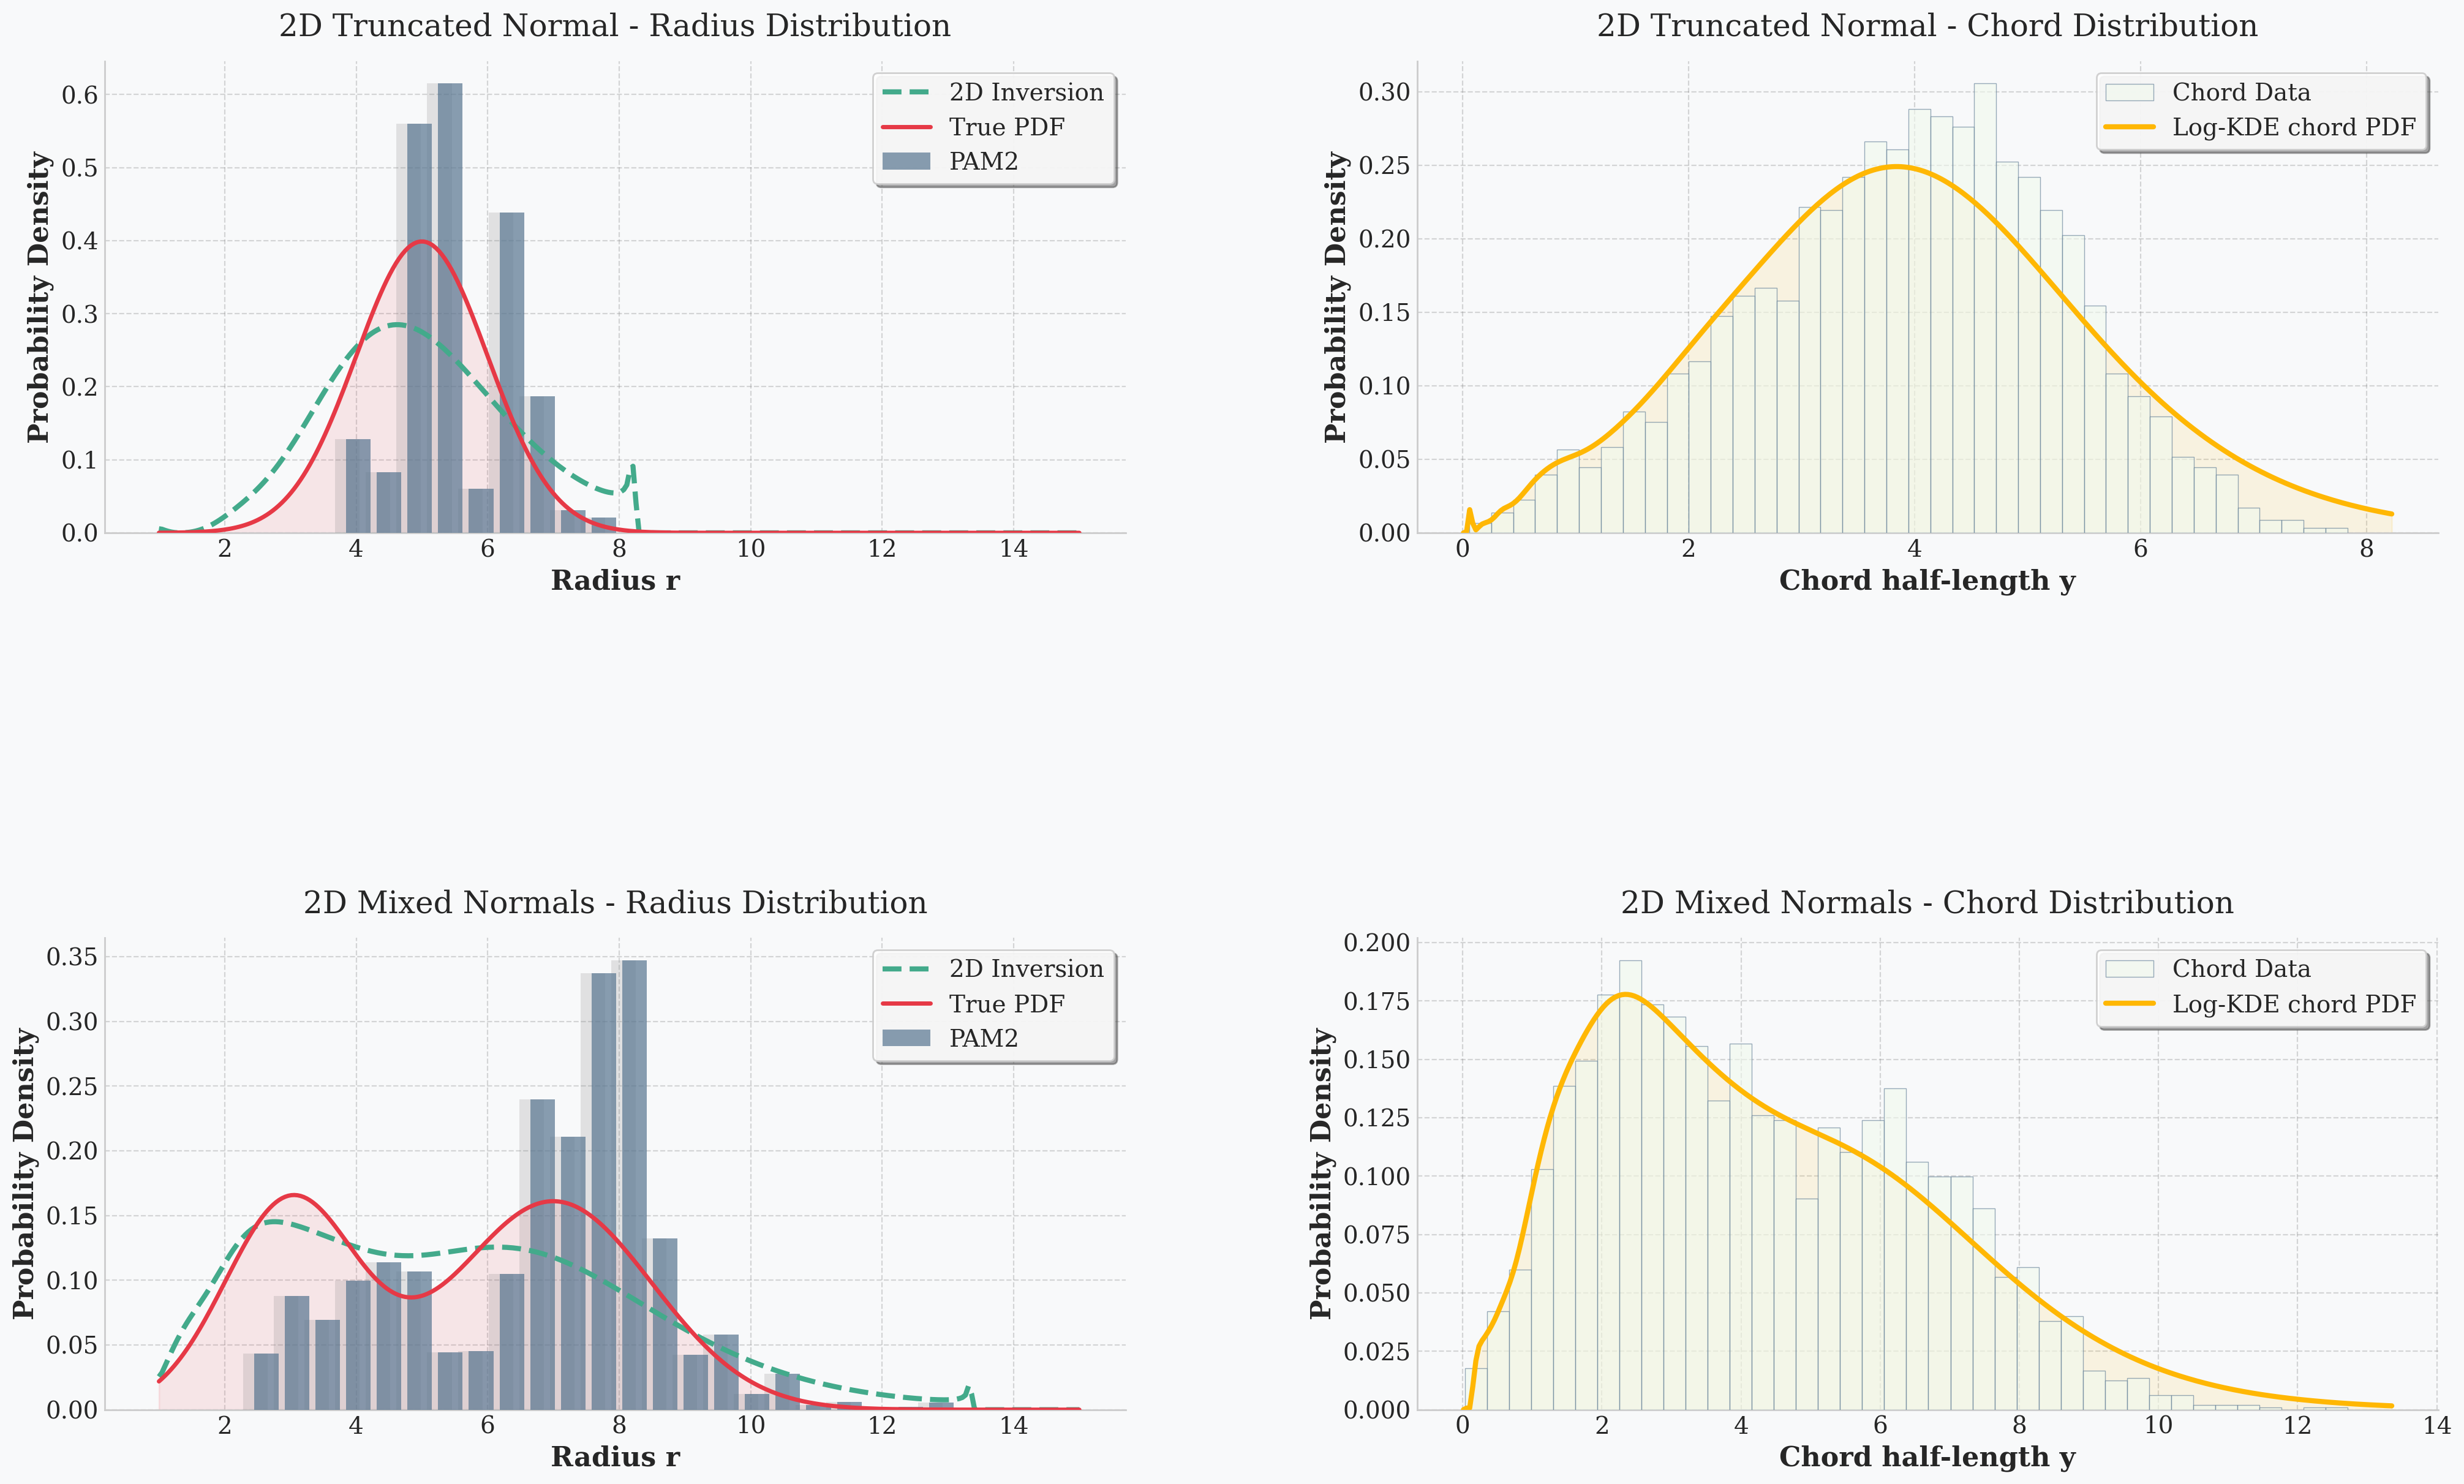

Analyzing 2D Log-Normal distribution...
Analyzing 2D Gamma distribution...
Creating Figure 2: 2D Lognormal and 2D Gamma...


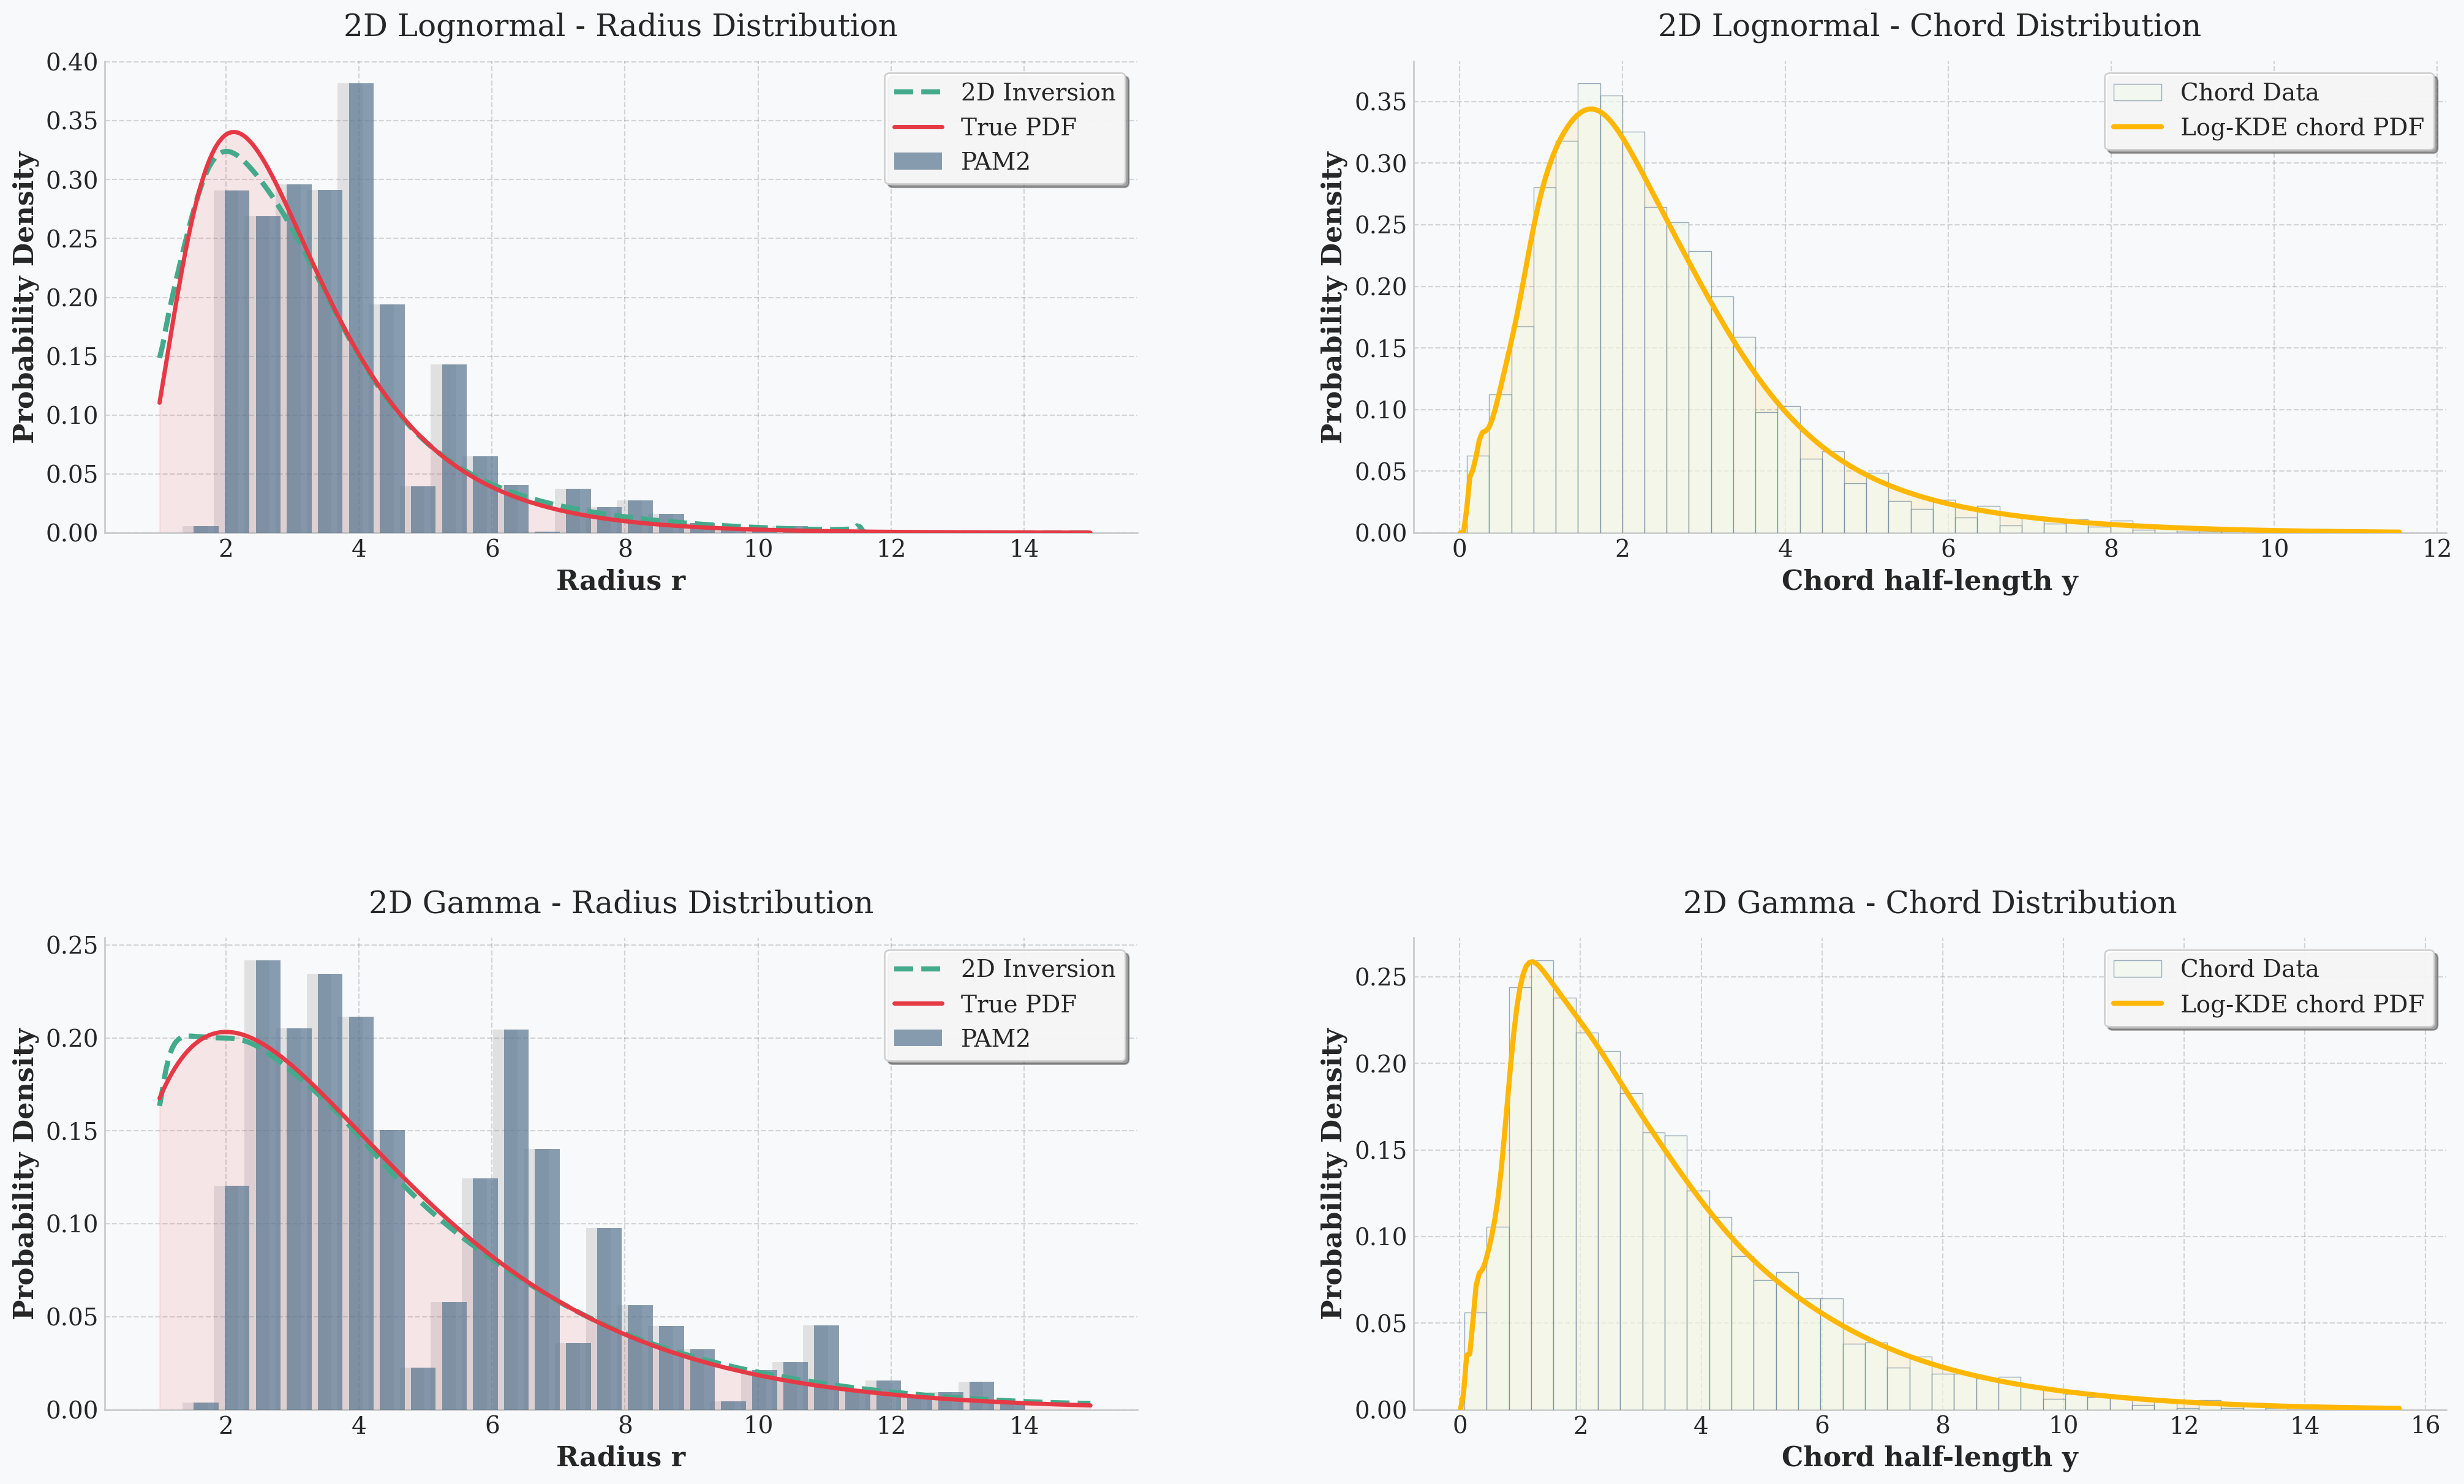

Analyzing 3D Normal distribution...
Analyzing 3D Mixed Normals distribution...
Creating Figure 3: 3D Normal and 3D Mixed Normals...


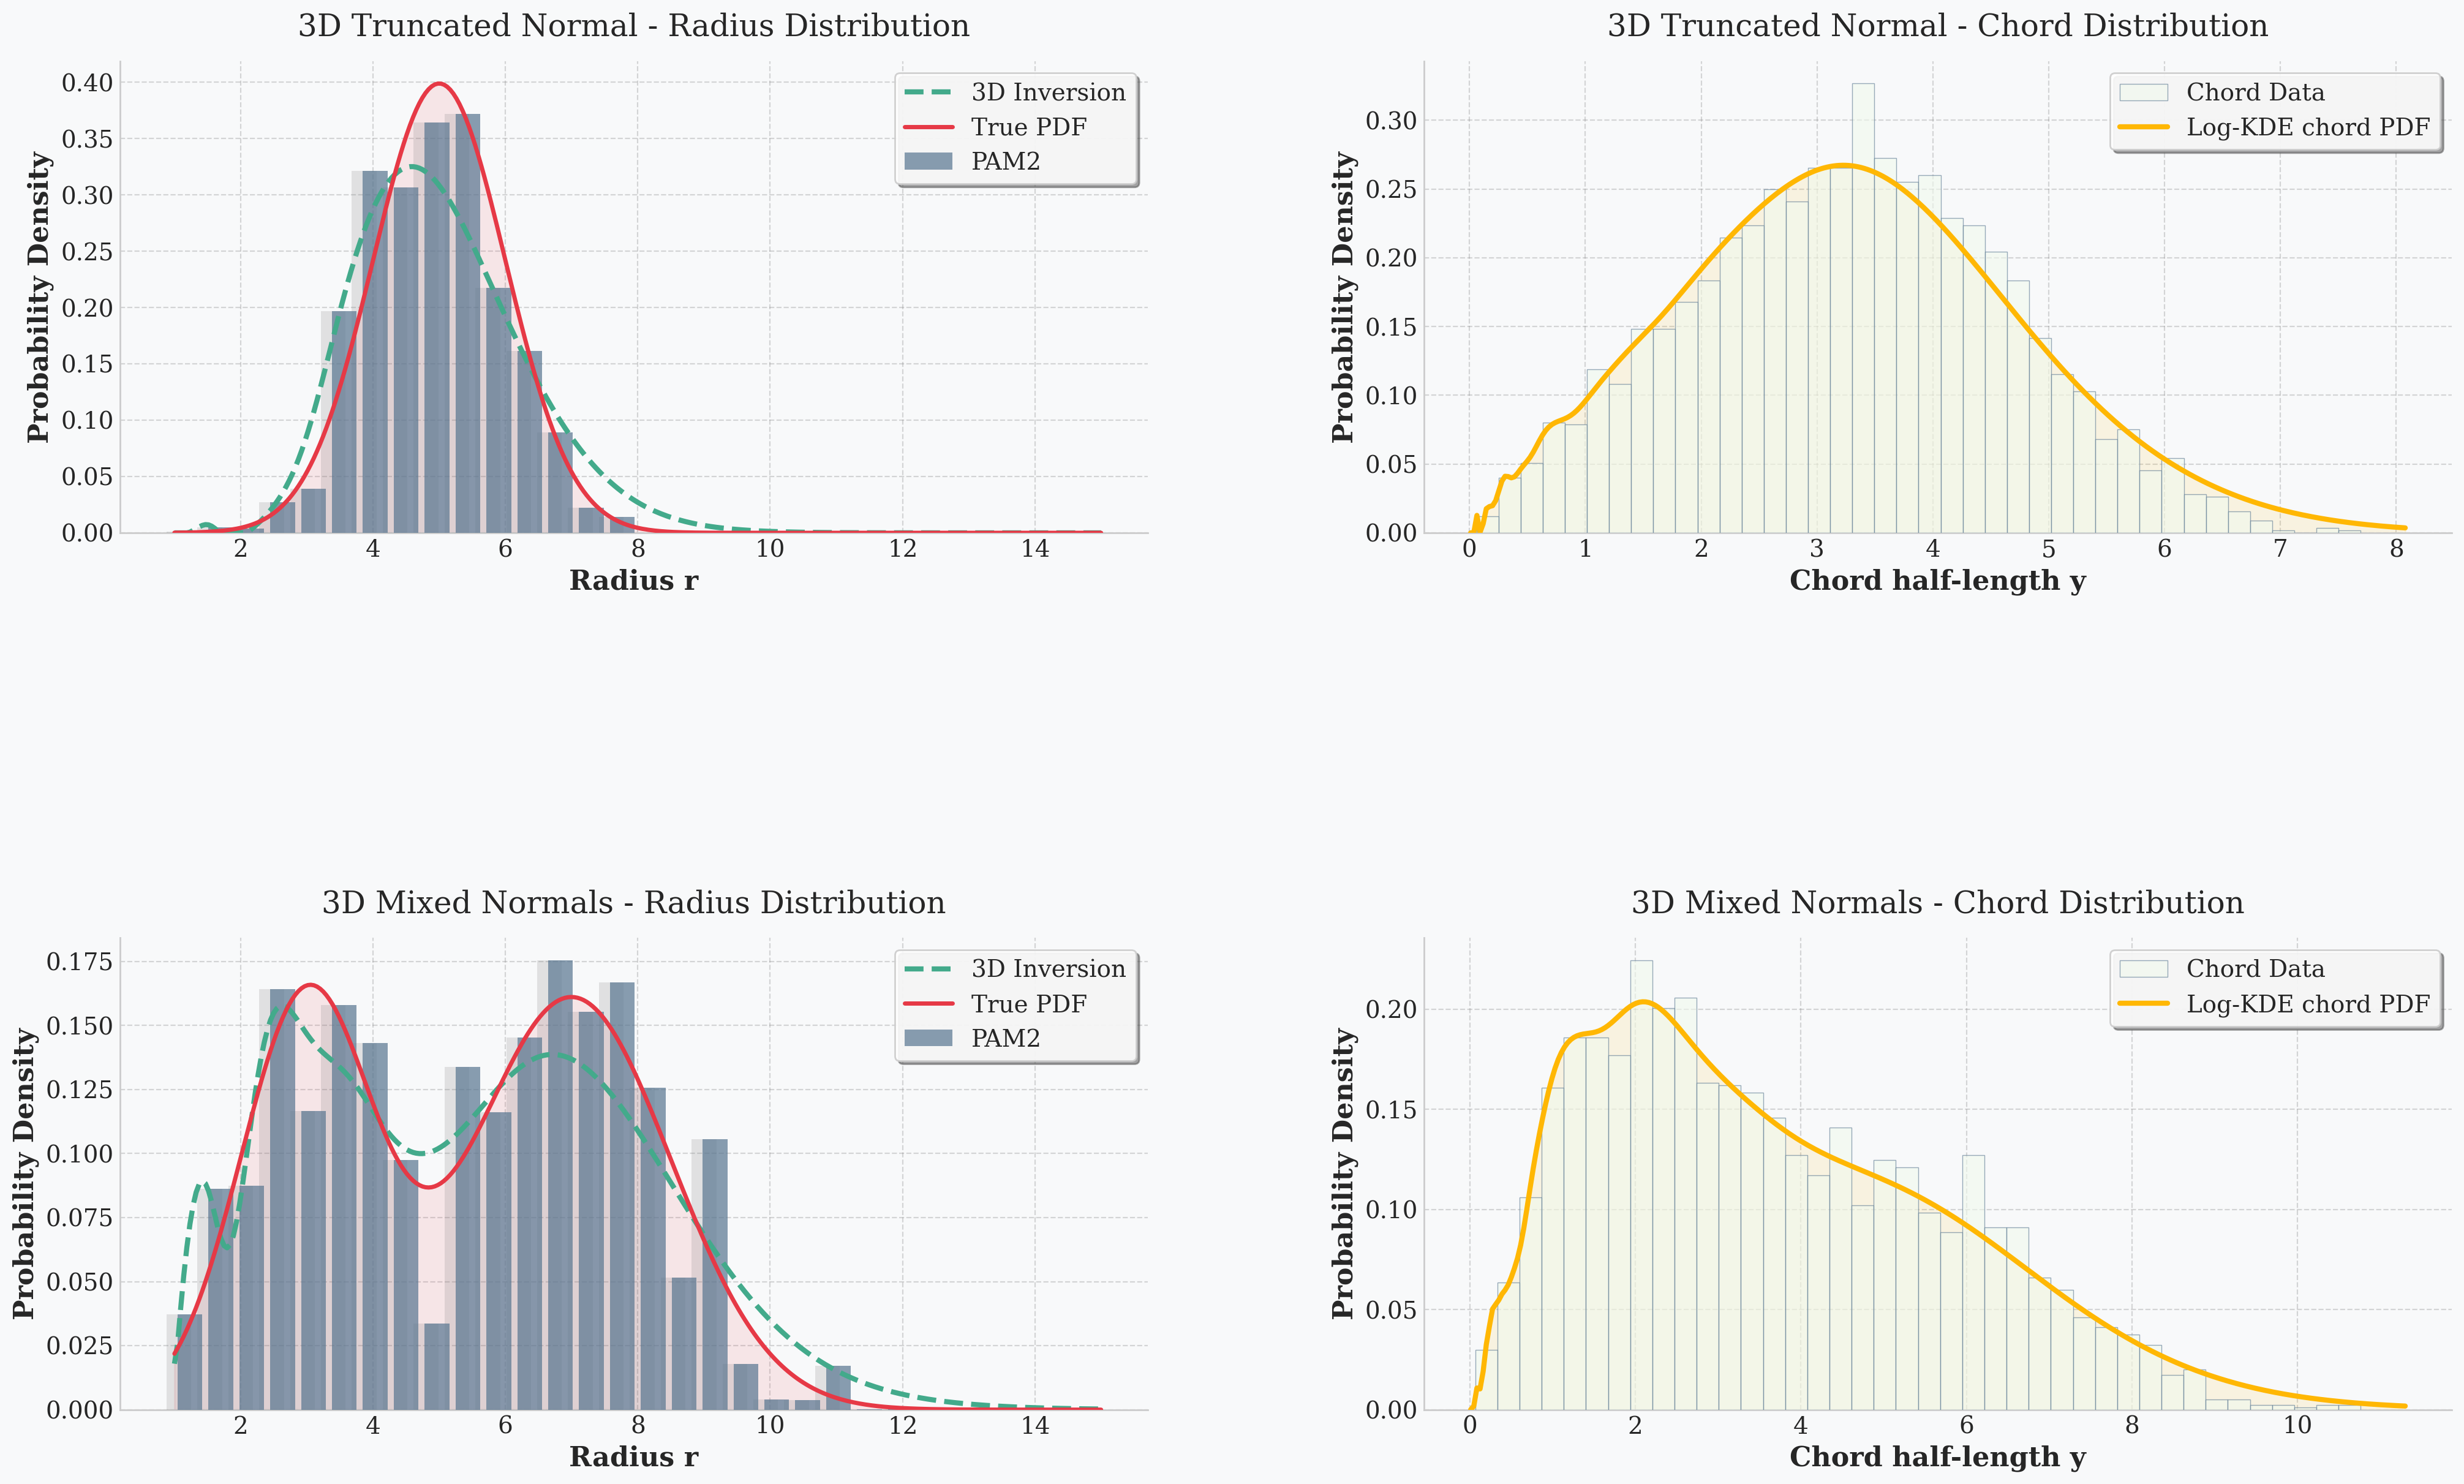

Analyzing 3D Log-Normal distribution...
Analyzing 3D Gamma distribution...
Creating Figure 4: 3D Lognormal and 3D Gamma...


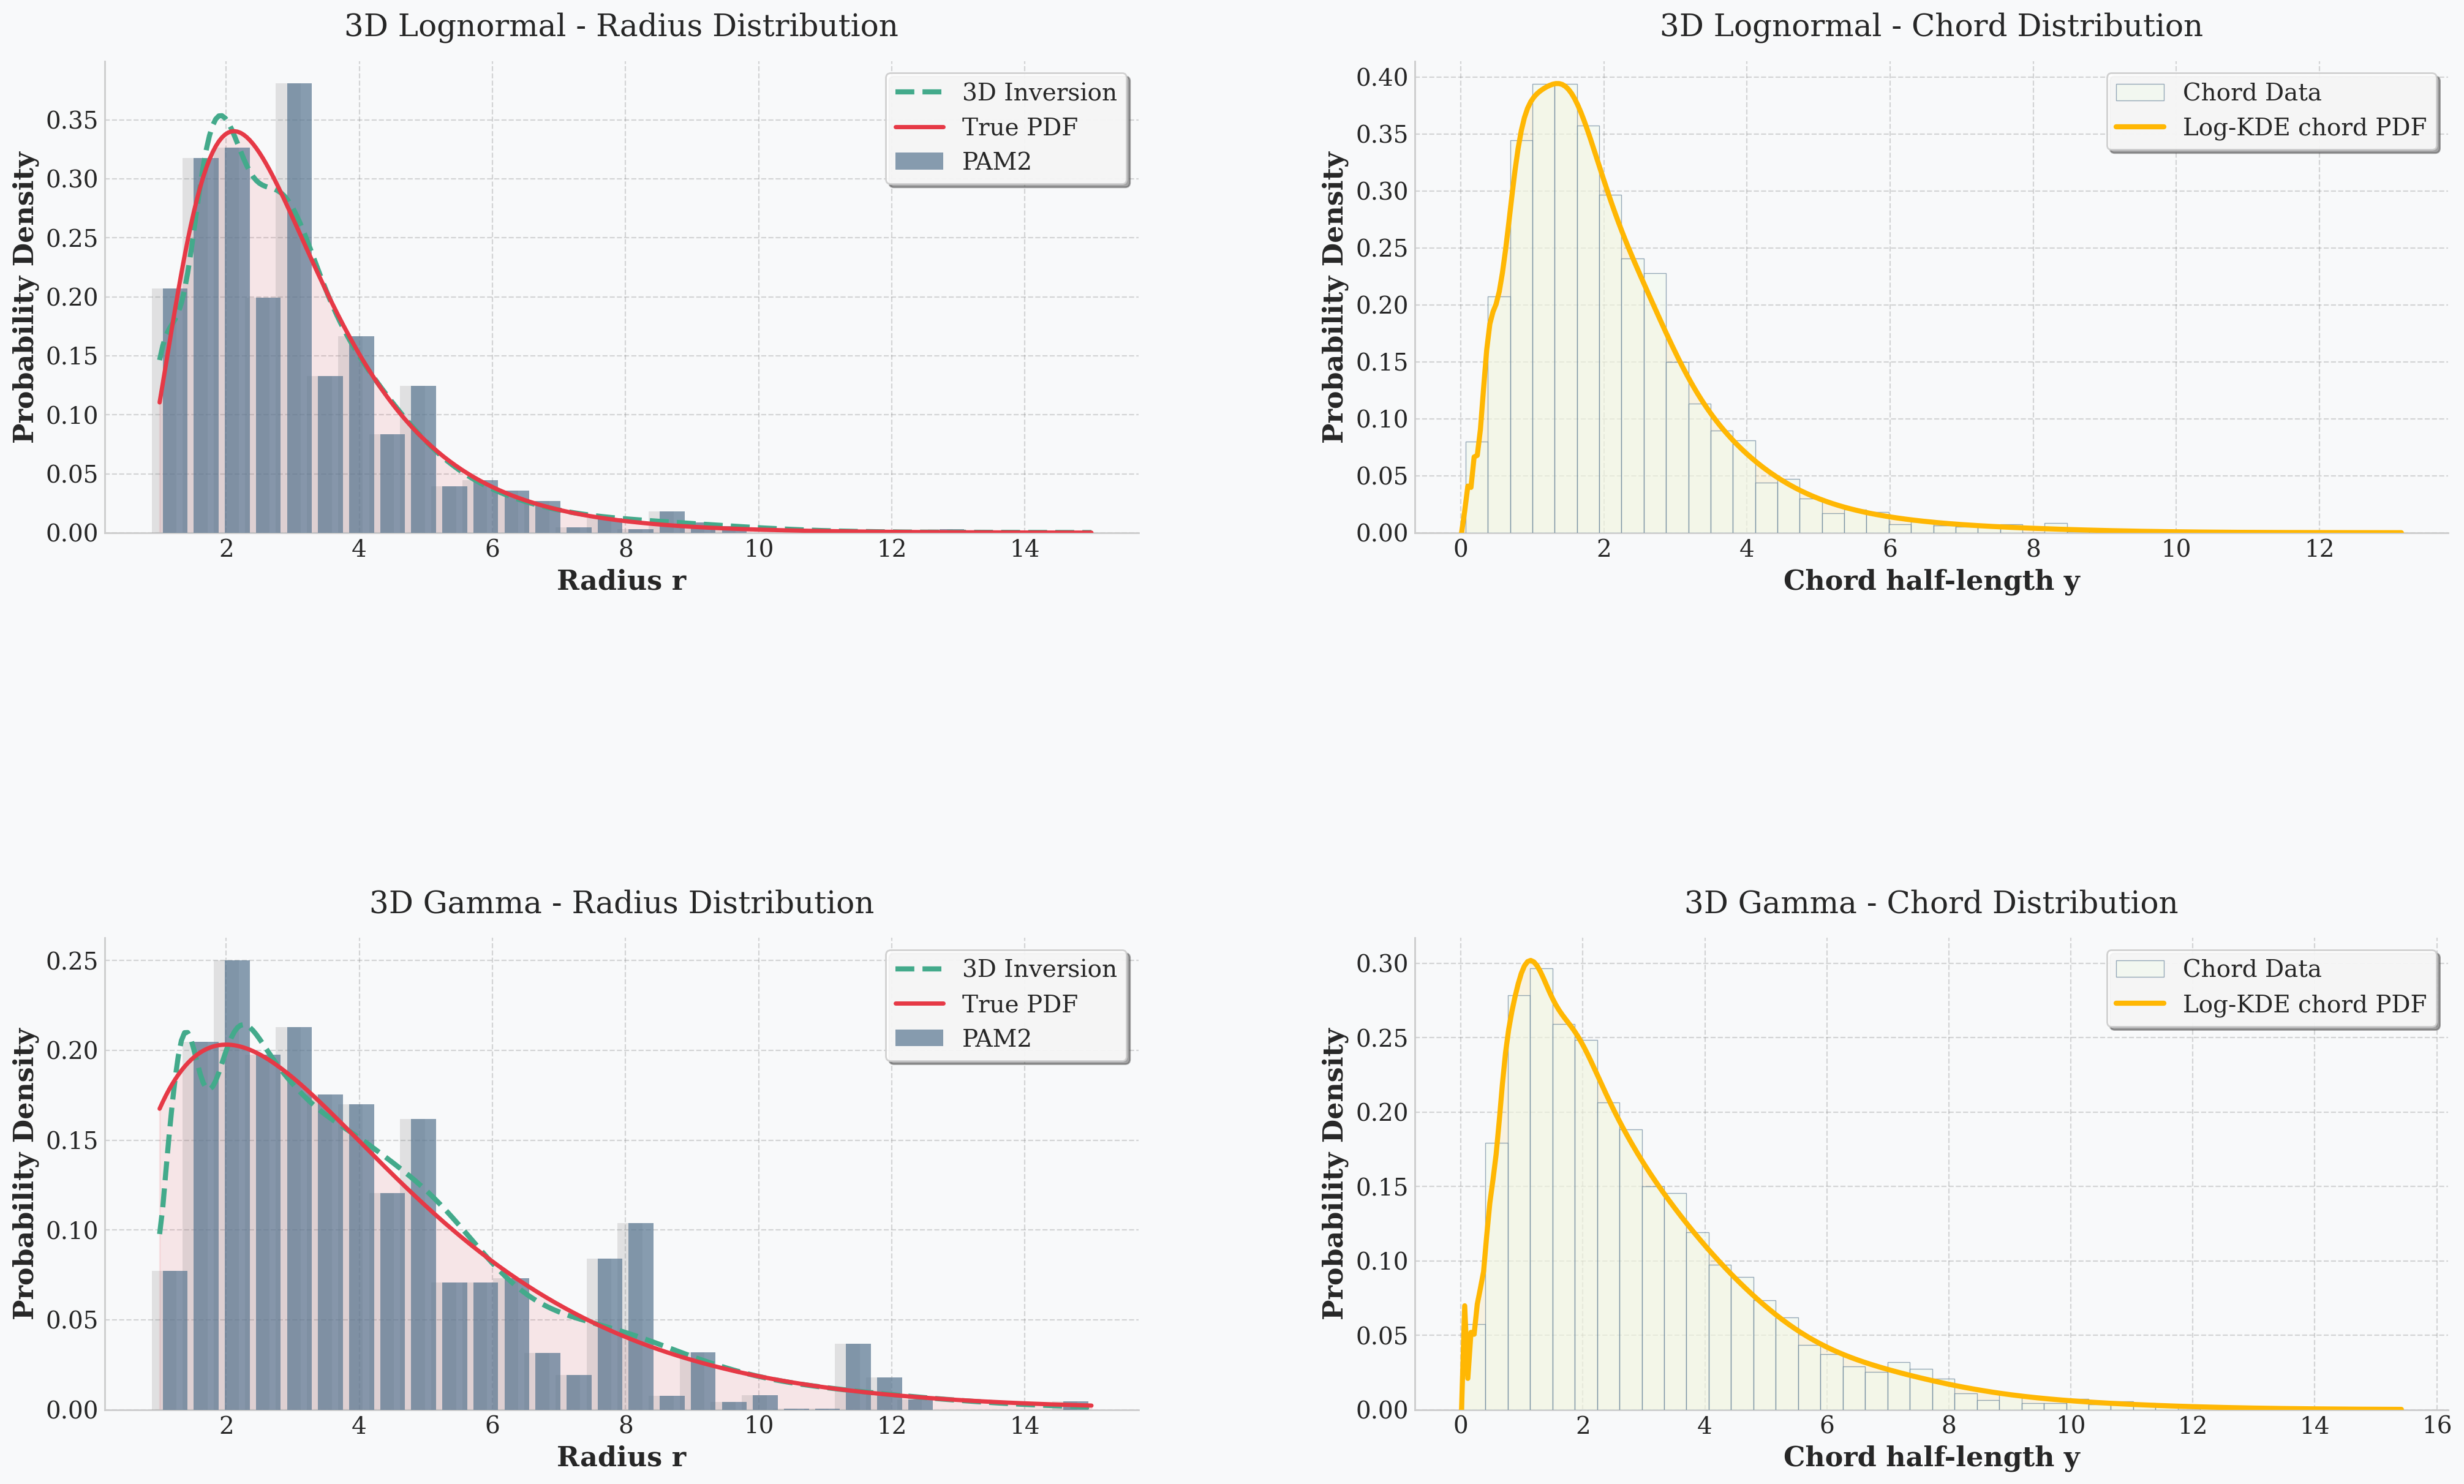

Analysis complete. All figures displayed.
Used 3000 samples with random seed 123.
To save figures, uncomment the savefig() lines in the plot_combined_results function.


In [13]:
def main():
    # Set a fixed random seed for reproducibility
    rng = np.random.default_rng(RANDOM_SEED)
    
    # Define the distributions for 2D and 3D
    normal_func = pdf_truncated_normal
    lognormal_func = pdf_lognormal
    gamma_func = pdf_gamma
    mixed_func = pdf_mixture_of_normals
    
    print(f"Starting analysis with {NUM_SAMPLES} samples and random seed {RANDOM_SEED}...")
    
    # 1. Figure 1: 2D Normal and 2D Mix of Normals
    print("Analyzing 2D Normal distribution...")
    normal_2d_results = analyze_distribution("2D Truncated Normal", normal_func, "2D", rng)
    
    print("Analyzing 2D Mixed Normals distribution...")
    mixed_2d_results = analyze_distribution("2D Mixed Normals", mixed_func, "2D", rng)
    
    print("Creating Figure 1: 2D Normal and 2D Mixed Normals...")
    plot_combined_results(normal_2d_results, mixed_2d_results, 
                          "figure1_2D_normal_mixed.png", "2D")
    
    # 2. Figure 2: 2D Log-Normal and 2D Gamma
    print("Analyzing 2D Log-Normal distribution...")
    lognormal_2d_results = analyze_distribution("2D Lognormal", lognormal_func, "2D", rng)
    
    print("Analyzing 2D Gamma distribution...")
    gamma_2d_results = analyze_distribution("2D Gamma", gamma_func, "2D", rng)
    
    print("Creating Figure 2: 2D Lognormal and 2D Gamma...")
    plot_combined_results(lognormal_2d_results, gamma_2d_results, 
                          "figure2_2D_lognormal_gamma.png", "2D")
    
    # 3. Figure 3: 3D Normal and 3D Mix of Normals
    print("Analyzing 3D Normal distribution...")
    normal_3d_results = analyze_distribution("3D Truncated Normal", normal_func, "3D", rng)
    
    print("Analyzing 3D Mixed Normals distribution...")
    mixed_3d_results = analyze_distribution("3D Mixed Normals", mixed_func, "3D", rng)
    
    print("Creating Figure 3: 3D Normal and 3D Mixed Normals...")
    plot_combined_results(normal_3d_results, mixed_3d_results, 
                          "figure3_3D_normal_mixed.png", "3D")
    
    # 4. Figure 4: 3D Log-Normal and 3D Gamma
    print("Analyzing 3D Log-Normal distribution...")
    lognormal_3d_results = analyze_distribution("3D Lognormal", lognormal_func, "3D", rng)
    
    print("Analyzing 3D Gamma distribution...")
    gamma_3d_results = analyze_distribution("3D Gamma", gamma_func, "3D", rng)
    
    print("Creating Figure 4: 3D Lognormal and 3D Gamma...")
    plot_combined_results(lognormal_3d_results, gamma_3d_results, 
                          "figure4_3D_lognormal_gamma.png", "3D")
    
    print("Analysis complete. All figures displayed.")
    print(f"Used {NUM_SAMPLES} samples with random seed {RANDOM_SEED}.")
    print("To save figures, uncomment the savefig() lines in the plot_combined_results function.")

# Execute the main function
main()

## 10. Conclusion

This notebook demonstrates the complete workflow for chord sampling and inversion in both 2D and 3D settings. The direct inversion formulas provide elegant mathematical solutions for reconstructing particle size distributions from chord measurements, comparing favorably with the iterative PAM2 approach.

Key findings:
1. Both direct inversion and PAM2 can effectively recover the underlying radius distribution
2. Log-space KDE provides effective smoothing across multiple size scales
3. The mathematical connection to Abel transforms offers a rich theoretical foundation

These methods have practical applications in particle characterization across multiple industries, including pharmaceuticals, mineral processing, and oil and gas production.